<a href="https://colab.research.google.com/github/Bayers-17/HCG-GIS-2024/blob/main/Easements_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install arcpy
!pip install arcgis


In [ ]:
#Import packages needed
import arcgis
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from arcgis.geometry import Geometry
from shapely.geometry import shape
import requests
from PIL import Image
from io import BytesIO
import numpy as np
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from arcgis.mapping import MapImageLayer
import random
import matplotlib

In [ ]:
!pip install contextily
import contextily as ctx

In [ ]:
username = 'Brayers@hcg'
password = '@Waterline.17'
gis = GIS("https://hcggis.harfordcountymd.gov/portalext", username, password)

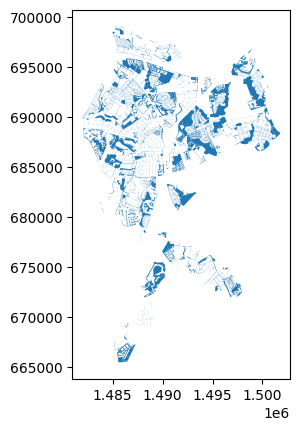

Index(['OBJECTID', 'Type', 'Source', 'Reference', 'URL', 'Shape__Area',
       'RecordationDate', 'GlobalID', 'geometry'],
      dtype='object')


In [ ]:
# Setting the URL to the feature service and make object
service_url = 'https://hcggis.harfordcountymd.gov/arcgis/rest/services/Easements/FeatureServer'
layer_id = 0
# Creating a feature layer object
feature_layer = FeatureLayer(service_url + f'/{layer_id}', gis=gis)
#This queries for the feature layer --> looks for it within the link
features = feature_layer.query(where='1=1', out_fields='*').features
# Convert to a GeoDataFrame using geopandas
#first I use shapely to create the geometries and put them into a format that cnabe read in by gpd
geometries = [Geometry(feature.geometry).as_shapely for feature in features]
#called for the geometries
attributes = [feature.attributes for feature in features]
#I used the geometries to make the geodataframe and converted the coordinate refernece system to the commonly used EPSG 4326
gdf = gpd.GeoDataFrame(attributes, crs='EPSG:4326', geometry=geometries)
# Plotted the GeoDataFrame and display it
fig, ax = plt.subplots()
gdf.plot(ax=ax, aspect='equal')
plt.show()
print(gdf.columns)

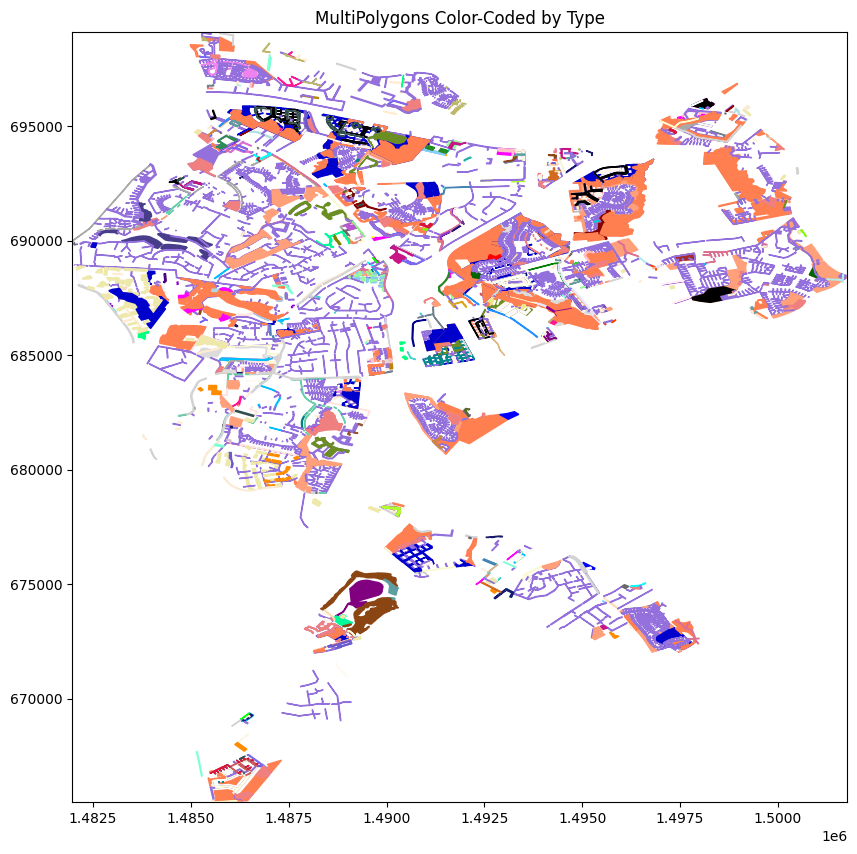

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from arcgis.features import FeatureLayer
from shapely.geometry import shape
import random
import matplotlib

gdf=gdf.to_crs(epsg=4326)
unique_types = gdf['Type'].unique()
num_colors = len(unique_types)

# Ensure num_colors does not exceed available CSS4 colors
available_colors = list(matplotlib.colors.CSS4_COLORS.values())
# Use all available colors if there are more unique types than colors
num_colors = min(num_colors, len(available_colors))
# Sample random colors
rand_colors = random.sample(available_colors, num_colors)
# Create color dictionary, handling cases where there are more unique types than colors
color_dict = {ctype: rand_colors[i % num_colors] for i, ctype in enumerate(unique_types)} # Use modulo operator (%) to cycle through colors if necessary
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figsize as needed
# Plot each MultiPolygon separately with its assigned color
for index, row in gdf.iterrows():
    ctype = row['Type']
    geom = row['geometry']
    if geom and not geom.is_empty and geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms:
            coords = list(polygon.exterior.coords)
            ax.add_patch(matplotlib.patches.Polygon(coords, color=color_dict.get(ctype, 'gray'), label=ctype)) # Use .get() with a default color to handle potential missing colors

plt.title('MultiPolygons Color-Coded by Type')

buffer_amount = 1  # Adjust this value to control how much to expand the bounds?
xmin, ymin, xmax, ymax = gdf.total_bounds
xmin -= buffer_amount
ymin -= buffer_amount
xmax += buffer_amount
ymax += buffer_amount
# Set axis limits with expanded bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

In [ ]:
#another way to calculate data using the columns
total_area = gdf['Shape__Area'].sum()/4046.86
print(total_area)

18760.617579066165


In [ ]:
#Now I am calculating the area of the geometies for a more accurate function
gdf_projected = gdf.to_crs(epsg= 32610)
#area calcualtion for each geometry
gdf_projected['area']= gdf.geometry.area
#Summing
total = gdf_projected['area'].sum()
print(total)
#converstion to acres
acres_total = total/4046.86
acres_total

69480521.36800957


<ipython-input-8-425fe61c58fc>:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_projected['area']= gdf.geometry.area


17168.995559028375

In [ ]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Assuming gdf is your GeoDataFrame with polygons
# Step 1: Project to the desired CRS (already done in your example)
gdf_projected = gdf.to_crs(epsg=32610)

# Step 2: Identify and filter out overlapping polygons and invalid geometries
filtered_geometries = []

# Use .items() instead of .iteritems() to iterate over GeoSeries
for idx, geom in gdf_projected.geometry.items():
    # Check if the geometry is valid before proceeding
    if geom is not None and geom.is_valid:
        is_overlapped = False
        # Similarly, use .items() here as well
        for other_idx, other_geom in gdf_projected.geometry.drop(idx).items():
            if other_geom is not None and other_geom.is_valid and geom.intersects(other_geom):
                is_overlapped = True
                break

        if not is_overlapped:
            filtered_geometries.append(geom)

# Create a GeoDataFrame with filtered geometries
gdf_filtered = gpd.GeoDataFrame(geometry=filtered_geometries, crs=gdf_projected.crs)

# Handle the case where no geometries are left after filtering
if gdf_filtered.empty:
    print("Warning: No non-overlapping geometries found.")
    total1_area = 0  # Or handle this case differently as needed
else:
    # Step 3: Calculate the area for each geometry
    gdf_filtered['area'] = gdf_filtered.geometry.area

    # Step 4: Union all valid geometries to create a single geometry
    union_geometry = gdf_filtered.geometry.unary_union
    total1_area = union_geometry.area

# Step 5: Convert to acres (if needed)
acres1_total = total1_area / 4046.86

print(acres1_total)

0.0


In [ ]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Now I am calculating the area of the geometries for a more accurate function
gdf_projected = gdf.to_crs(epsg=32610)

# Area calculation for each geometry
gdf_projected['Shape_Area'] = gdf.geometry.area

# Check if the GeoDataFrame is empty
if gdf_projected.empty:
    print("Error: The GeoDataFrame is empty. Check the data source.")
else:
    # Remove invalid geometries
    gdf_projected = gdf_projected[gdf_projected.geometry.is_valid]

    # Check if any geometries remain after removing invalid ones
    if gdf_projected.empty:
        print("Error: All geometries were invalid.")
    else:
        # Union all valid geometries to create a single geometry
        union_geometry = gdf_projected.geometry.unary_union
        total2_area = union_geometry.area
        acres2_total = total2_area / 4046.86
        print(acres2_total)

Error: All geometries were invalid.


<ipython-input-10-e89fa06b535c>:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_projected['Shape_Area'] = gdf.geometry.area


In [ ]:
!pip install dash
!pip install jupyter-dash

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np




**THIS IS THE ONE THAT WORKS WITH THE NEW CALCULATION OF TOTAL ACRES** :) :)

In [ ]:
def calc_perday_per (people, days_per_week, weeks, total_acreage):
  per_person = total_acreage / (people)
  per_week = per_person/weeks
  per_day = per_week/days_per_week
  return per_day

per_day_person = calc_perday_per(2,5,6,acres_total)
print(acres_total)
print(per_day_person)


#The only problem witht his acreage calculation is that it takes into consideration the easments that have multiple layers on top of eachother.
#This makes it look like we have more done than we acually do. So for that case we should make our final goal margins a little less constrained.

17168.995559028375
286.14992598380627


In [ ]:

# Initialize
app = dash.Dash(__name__)
# App layout
app.layout = html.Div(children=[
    html.H1(children="Acreage Covered Over Time Comparison"),

    html.Div([
        "Number of People (Team 1): ",
        dcc.Slider(
            id='people-slider',
            min=0,
            max=20,
            step=1,
            value=5,
            marks={i: str(i) for i in range(1, 21)}
        )
    ]),

    html.Div([
        "Days Worked per Week (Team 1): ",
        dcc.Slider(
            id='days-slider',
            min=1,
            max=7,
            step=1,
            value=5,
            marks={i: str(i) for i in range(1, 6)}
        )
    ]),

    html.Div([
        "Number of People (Team 2): ",
        dcc.Slider(
            id='people2-slider',
            min=0,
            max=20,
            step=1,
            value=5,
            marks={i: str(i) for i in range(1, 21)}
        )
    ]),

    html.Div([
        "Days Worked per Week (Team 2): ",
        dcc.Slider(
            id='days2-slider',
            min=1,
            max=7,
            step=1,
            value=5,
            marks={i: str(i) for i in range(1, 6)}
        )
    ]),

    dcc.Graph(id='acreage-graph')
])



# Define
goal = 60000
def calculate1(people, weeks, days, goal, per_day_person):
    acreage = per_day_person * people * weeks * days
    acreage = np.round(acreage, 2)
    return acreage

# Callback function
@app.callback(
    Output('acreage-graph', 'figure'),
    [Input('people-slider', 'value'),
     Input('days-slider', 'value'),
     Input('people2-slider', 'value'),
     Input('days2-slider', 'value')]
)
def update_graph(people1, days1, people2, days2):
    weeks = np.linspace(0, 100, 1000)
    acreage1 = calculate1(people1, weeks, days1, goal, per_day_person)
    acreage2 = calculate1(people2, weeks, days2, goal, per_day_person)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=weeks, y=acreage1, mode='lines', name='Team 1'))
    fig.add_trace(go.Scatter(x=weeks, y=acreage2, mode='lines', name='Team 2'))

    fig.update_layout(
        title='Acreage Covered Over Time',
        xaxis_title='Weeks',
        yaxis_title='Acreage',
        yaxis_range=[0, goal]
    )

    if any(np.max(acreage) >= goal for acreage in [acreage1, acreage2]):
      fig.add_annotation(
        x=weeks[np.argmax(acreage1 >= goal)],
        y=goal,
        text=f'Team 1: Goal Reached ~({goal} acres) in {weeks[np.argmax(acreage1 >= goal)].round(2)} weeks',
        showarrow=True,
        arrowhead=1
    )
      fig.add_annotation(
        x=weeks[np.argmax(acreage2 >= goal)],
        y=goal,
        text=f'Team 2: Goal Reached ~({goal} acres) in {weeks[np.argmax(acreage2 >= goal)].round(2)} weeks',
        showarrow=True,
        arrowhead=1,
        ax=30,
        yshift=10
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)




<IPython.core.display.Javascript object>

In [ ]:
#What was used in ArcGIS pro for area calculation, This code cannot be used in CoLab

# Set workspace and map document
arcpy.env.workspace = r"H:\Broooke_edits\Brayers Edits\Cityworks\GIS Services\ArcProProjects\UtilityNetworksWSIM\Default.gdb"
mxd = arcpy.mp.ArcGISProject("CURRENT")
map = mxd.listMaps("Layers")[0]
layer = map.listLayers("WSIM.SDE.Easements")[0]

desc = arcpy.Describe(layer)
spatial_ref = desc.spatialReference
fields = ['SHAPE@AREA']
total_acres = 0.0

with arcpy.da.SearchCursor(layer, fields, spatial_reference=spatial_ref) as cursor:
    for row in cursor:
        area_sq_meters = row[0]
        if area_sq_meters is not None:
            area_acres = area_sq_meters * 0.000247105
            total_acres += area_acres

print(f"Total Acres: {total_acres}")

# Clean up
del mxd
# Total Acres: 13587.243869441007

NameError: name 'arcpy' is not defined